In [ ]:
#회귀, 분류분석을 위해 install해야 하는 라이브러리
!pip install category_encoders # 원핫인코딩을 위해 category_encoders 라이브러리를 설치
!pip3 install xgboost
!pip3 install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_csv("/content/drive/MyDrive/PonderosaPine_out.csv")

# Cover_Type, 'Cover_Type_Tree'가 있으면 데이터 누수가 발생(정답이므로,,,)하므로 삭제, 
# object는 category 로 자료형 변경
# df = df.drop(columns = ['Cover_Type','Cover_Type_Tree'], axis=1)
df['Area'] = df['Area'].astype('category')
df['Soil_Type'] = df['Soil_Type'].astype('category')
df['PonderosaPine'] = df['PonderosaPine'].astype('category')
# df['PonderosaPine'] = df['PonderosaPine'].replace({'No':0, 'Yes':1}).astype('category')

df.info()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290332 entries, 0 to 290331
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   Elevation                           290332 non-null  int64   
 1   Aspect                              290332 non-null  int64   
 2   Slope                               290332 non-null  int64   
 3   Horizontal_Distance_To_Hydrology    290332 non-null  int64   
 4   Vertical_Distance_To_Hydrology      290332 non-null  int64   
 5   Horizontal_Distance_To_Roadways     290332 non-null  int64   
 6   Hillshade_9am                       290332 non-null  int64   
 7   Hillshade_Noon                      290332 non-null  int64   
 8   Hillshade_3pm                       290332 non-null  int64   
 9   Horizontal_Distanc

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Area,Soil_Type,PonderosaPine
0,2621,162,13,60,-6,849,232,243,139,1521,Comanche Peak,Soil_Type20,No
1,2664,112,5,60,-8,1214,229,234,139,1719,Comanche Peak,Soil_Type20,No
2,2633,68,8,42,2,979,228,225,130,1594,Comanche Peak,Soil_Type20,No
3,2662,105,5,30,-3,1211,228,234,140,1731,Comanche Peak,Soil_Type20,No
4,2674,10,8,30,1,1295,211,224,149,1801,Comanche Peak,Soil_Type20,No


타겟데이터의 비율
 No     0.876851
Yes    0.123149
Name: PonderosaPine, dtype: float64


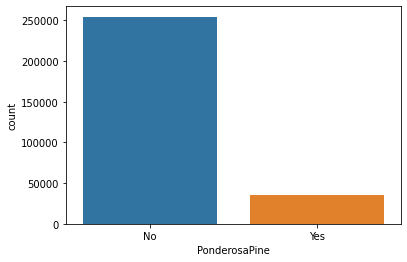

In [ ]:
y =  df['PonderosaPine']
print("타겟데이터의 비율\n",y.value_counts(normalize=True))

%matplotlib inline
sns.countplot(x=y);

In [ ]:
# train, validation, test set으로 먼저 나눠주겠습니다.

from sklearn.model_selection import train_test_split

# 타겟값이 문자형이기 때문에 수치형으로 바꿔주겠습니다.
# df['PonderosaPine'] = df['PonderosaPine'].replace({'No':0, 'Yes':1}).astype('category')

y = df['PonderosaPine']
X = df.drop('PonderosaPine', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (163311, 12)
X_val shape:  (54438, 12)
X_test shape:  (72583, 12)


In [ ]:
from hyperopt import hp

params = {
    "xgbclassifier__max_depth": hp.quniform("max_depth", 15, 30, 5),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
    "xgbclassifier__subsample": hp.uniform("subsample", 0.6, 1.0),
}

In [ ]:
## 베이지안 튜닝

from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import numpy as np


def get_pipe(params):
    params["xgbclassifier__max_depth"] = int(
        params["xgbclassifier__max_depth"]
    )  # max_depth는 정수형으로 변환해 줍니다.
    pipe = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy="median"),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            n_estimators= 200,
            random_state= 42,
            n_jobs=-1,
            learning_rate= 0.1,
            use_label_encoder= False,
        ),
    )
    pipe = pipe.set_params(**params)
    return pipe

def fit_and_eval(params):
    pipe = get_pipe(params)  # 주어진 params로 파이프라인을 만들어 가져옵니다.
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="roc_auc")
    avg_cv_score = np.mean(score)
    # roc_auc는 클수록 좋은 metric이므로, hyperopt.fmin이 roc_auc를 최대화하도록 하기 위해 -부호를 붙여 반환합니다.
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = (
    Trials()
)  # Trials() 객체를 fmin에 함께 넣어 실행하면, 실행되는 매 fit의 학습 정보 및 학습 결과가 해당 객체에 모두 저장됩니다.

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=10
)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색합니다.

100%|██████████| 10/10 [34:53<00:00, 209.34s/it, best loss: -0.9987946055709213]


In [ ]:
trials.trials  # 모든 trial 정보에 대해 직접 접근할 수 있습니다.

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.9985988338974048, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [0], 'max_depth': [0], 'subsample': [0]},
   'vals': {'colsample_bytree': [0.8857554854727141],
    'max_depth': [15.0],
    'subsample': [0.6179564741140132]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 9, 29, 14, 55, 1, 783000),
  'refresh_time': datetime.datetime(2022, 9, 29, 14, 58, 6, 263000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.9986526840762894, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [1], 'max_depth': [1], 'subsample': [1]},
   'vals': {'colsample_bytree': [0.7833134801099139],
    'max_depth': [20.0],
    'subsample': [0.7285652817956231]}},
  'exp_key': None,
  'owner': None,


In [ ]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 AUC: ", -trials.best_trial["result"]["loss"])

# 최적 하이퍼파라미터:  {'colsample_bytree': [0.9225910636154233], 'max_depth': [30.0], 'subsample': [0.8297269242258191]}
# 최적 AUC:  0.9987946055709213

최적 하이퍼파라미터:  {'colsample_bytree': [0.9225910636154233], 'max_depth': [30.0], 'subsample': [0.8297269242258191]}
최적 AUC:  0.9987946055709213


In [ ]:
# XG부스트 모델
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline


pipe_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
        n_estimators=1000,
        random_state=42,
        n_jobs=-1,
        max_depth=30,
        learning_rate=0.1,
        colsample_bytree=0.92,
        subsample=0.83,
        scale_pos_weight = 7,
    ),
)
print(pipe_gb)

pipe_gb.fit(X_train, y_train)
print("훈련 정확도: ", pipe_gb.score(X_train, y_train))
print("검증 정확도: ", pipe_gb.score(X_val, y_val))


Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(colsample_bytree=0.92, eval_metric='error',
                               max_depth=30, n_estimators=1000, n_jobs=-1,
                               random_state=42, scale_pos_weight=7,
                               subsample=0.83))])
훈련 정확도:  1.0
검증 정확도:  0.9898600242477681


In [ ]:
y_pred_gb = pipe_gb.predict(X_val)
print(classification_report(y_val, y_pred_gb))

              precision    recall  f1-score   support

          No       1.00      0.99      0.99     47734
         Yes       0.95      0.97      0.96      6704

    accuracy                           0.99     54438
   macro avg       0.97      0.98      0.98     54438
weighted avg       0.99      0.99      0.99     54438



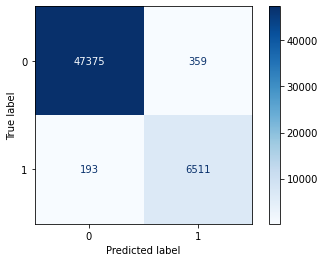

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()
    
plot_confusion_matrix(pipe_gb, X_val, y_val)

In [ ]:
# 일반화 성능확인<<< 중요.. 중요...>>

y_pred_gb_test = pipe_gb.predict(X_test)
y_pred_proba_test = pipe_gb.predict_proba(X_test)[:, 1]

print("테스트 accuracy", pipe_gb.score(X_test, y_test))
print("테스트 AUC", roc_auc_score(y_test, y_pred_proba_test))
print(classification_report(y_test, y_pred_gb_test))

테스트 accuracy 0.9914167229241007
테스트 AUC 0.9992452224673386
              precision    recall  f1-score   support

          No       1.00      0.99      1.00     63645
         Yes       0.96      0.98      0.97      8938

    accuracy                           0.99     72583
   macro avg       0.98      0.98      0.98     72583
weighted avg       0.99      0.99      0.99     72583



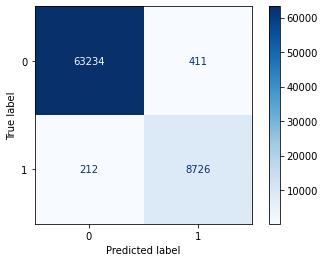

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()
    
plot_confusion_matrix(pipe_gb, X_test, y_test)

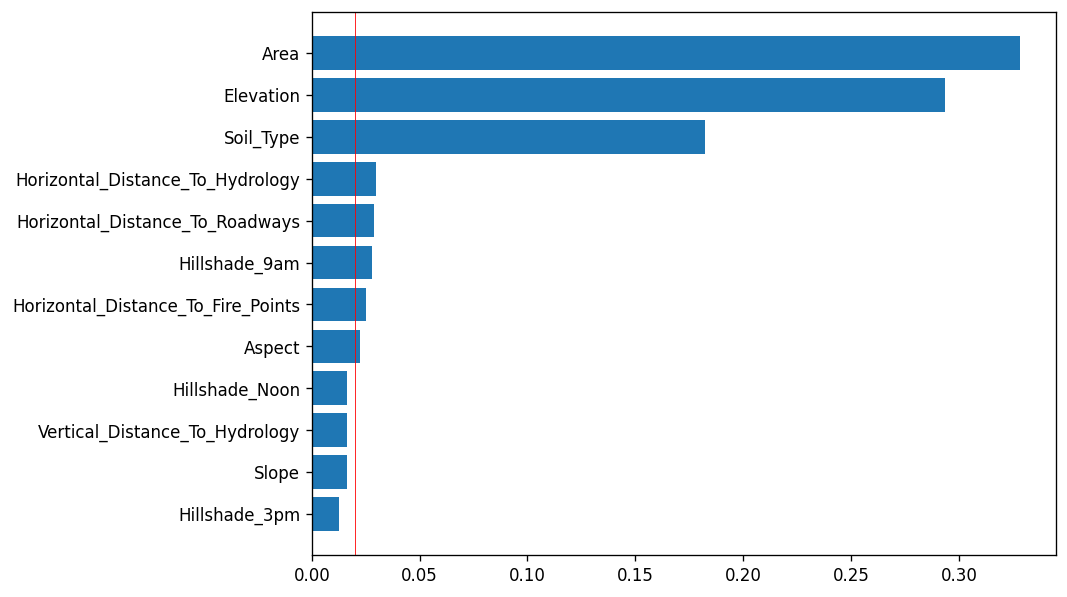

In [ ]:
import matplotlib.pyplot as plt

feature_importances = list(
    zip(X_train.columns, pipe_gb.named_steps["xgbclassifier"].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(8, 6), dpi=120)
plt.barh(*list(zip(*feature_importances[::-1])))
plt.axvline(0.02, color="red", linewidth=0.5)

In [ ]:
features_selected = list(filter(lambda x: x[1] >= 0.02, feature_importances))
print(features_selected)
selected_feature_names = list(map(lambda x: x[0], features_selected))

[('Area', 0.3285049), ('Elevation', 0.29342338), ('Soil_Type', 0.18245049), ('Horizontal_Distance_To_Hydrology', 0.02997858), ('Horizontal_Distance_To_Roadways', 0.028876994), ('Hillshade_9am', 0.02786801), ('Horizontal_Distance_To_Fire_Points', 0.024920924), ('Aspect', 0.0224095)]


In [ ]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
        n_estimators=1000,
        random_state=42,
        n_jobs=-1,
        max_depth=30,
        learning_rate=0.1,
        colsample_bytree=0.92,
        subsample=0.83,
        scale_pos_weight = 7,
    ),
)

pipe.fit(X_train_selected, y_train)
print("검증 AUC: ", pipe.score(X_val_selected, y_val))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

검증 AUC:  0.9898600242477681
특성 수:
	Before:  12
	After:  8
